# Sentiment Analysis of Twitter Posts

<!-- Notebook name goes here -->
<center><b>Notebook: MultiNaive Bayes Model, Error Analysis, and Tuning</b></center>
<br>

**By**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**Dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**Motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**Goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.


# **1. Project Set-up**


In [22]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath("../lib"))
from anal_ysis_tools import (
    evaluate_classifier,
    check_feature_sparsity,
    high_lift_words,
)

# **2. Data Set-up**


In [23]:
import IPython.core.page
import builtins
from IPython.utils.capture import capture_output

pager = IPython.core.page.page
helper = builtins.help

IPython.core.page.page = lambda *args, **kwargs: None
builtins.help = lambda *args, **kwargs: None

try:
    with capture_output():
        %run data.ipynb
finally:
    IPython.core.page.page = pager
    builtins.help = helper

print("Data Setup is DONE")

# Tests
assert X.shape == (162_801, 29318), "Feature matrix shape is wrong; expected (162_801, 29318)"
assert y.shape == (162_801,), "Labels shape is wrong; expected (162_801,)"

assert X_train.shape == (113_960, 29_318), "Train shape is wrong; expected (113_960, 2)"
assert X_test.shape == (48_841, 29_318), "Test shape is wrong; expected (48_841, 2)"

assert y_train.shape == (113_960,), "Train labels shape is wrong; expected (113_960,)"
assert y_test.shape == (48_841,), "Test labels shape is wrong; expected (48_841,)"

print("All tests passed.")

Data Setup is DONE
All tests passed.


# **3. Model Selection**


# **4. Training the model**


## **Baseline Model**


Start off with training the model on a random hyperparameter and an imbalanced dataset to see its preformance at its worst.


In [24]:
model = MultinomialNB(alpha=0)  # HYPERPARAMETER ALPHA

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

a:\College\Year 3\Term 2\STINTSY\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\naive_bayes.py:930: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


Now that we have trained the baseline lets look at the results.


In [25]:
evaluate_classifier(model, y_pred, y_test, show_cm=False, digits=4)

Accuracy: 0.7188427755369464

Classification Report:

              precision    recall  f1-score   support

          -1     0.5837    0.6608    0.6198     10743
           0     0.7913    0.6913    0.7379     16542
           1     0.7457    0.7689    0.7571     21556

    accuracy                         0.7188     48841
   macro avg     0.7069    0.7070    0.7050     48841
weighted avg     0.7255    0.7188    0.7204     48841



array([ 0,  0,  1, ..., -1, -1,  0], shape=(48841,))

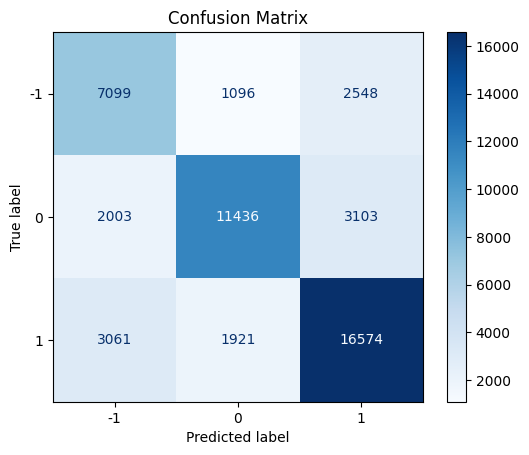

In [26]:
cm = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", display_labels=[-1, 0, 1]
)
plt.title("Confusion Matrix")
plt.show()

Findings:

- Accuracy of 71.88 prec.

- Model struggles most with class -1. It predicts -1 a lot incorrectly, and it also misses a chunk of real -1s.
- It predicts 0, it’s usually right, but it fails to catch a decent amount of real 0s (recall is lower).
- The model is both accurate and good at finding real class 1.
- The imbalance of the data often causes the minority class to do worse and that is reflected here.


## **Error Analysis**


Let us try to understand why the baseline model is having a hard time predicting some classes.


First check the common words in each failed prediction of a class


In [27]:
def top_wrong_words_of_label(y_pred, X_test, y_test, bow, label, top_n=20):
    """
    Returns the top words contributing to wrong predictions for a specific predicted label.
    """

    mask = (y_pred == label) & (y_test != label).to_numpy()

    X_wrong_pred = X_test[mask]
    word_counts = X_wrong_pred.sum(axis=0).A1  # convert sparse to 1D array
    feature_names = bow.vectorizer.get_feature_names_out()

    df_words = pd.DataFrame({"word": feature_names, "count": word_counts}).sort_values(
        "count", ascending=False
    )

    return df_words.head(top_n)

In [28]:
top_wrong_words_of_label(y_pred, X_test, y_test, bow, label=-1, top_n=10)

,word,count
15971,modi,4900
11771,india,768
797,all,759
20220,people,625
14352,like,570
2975,bjp,509
5101,congress,509
51,about,461
19310,only,422
10112,govt,412


In [29]:
top_wrong_words_of_label(y_pred, X_test, y_test, bow, label=0, top_n=10)

,word,count
15971,modi,3159
11771,india,471
7680,election,325
2975,bjp,319
18411,narendra,314
5101,congress,303
18416,narendra modi,281
28170,vote,277
797,all,258
19310,only,219


In [30]:
top_wrong_words_of_label(y_pred, X_test, y_test, bow, label=1, top_n=10)

,word,count
15971,modi,4942
11771,india,1157
797,all,674
2975,bjp,545
20220,people,510
14352,like,484
7680,election,441
28170,vote,440
5616,country,382
5101,congress,381


Observations:

- Some words like "modi", "india", "all", "bjp", "congress" appear in all classes as top wrong words.
- These are very common across the dataset → low discriminative power.
- These could be “confusing words” for the model.
- Counts for "modi" are very high in all classes (4900 in -1, 3159 in 0, 4942 in 1).
- The model sees this word everywhere → it’s not helping it distinguish classes.

Minor differences in counts for some words per class:

- "people" is high in -1 and 1 but not in 0
- "narendra" and "narendra modi" appear mostly in 0
- "election" appears mostly in 0 and 1

Overall, these counts suggest:

- Ambiguous words dominate misclassifications
- Some words appear across all classes → they contribute to borderline/ambiguous predictions
- Rare or less frequent words might be underweighted by smoothing (alpha) → you’ll see that later


Looks like we cannot rely on the most popular words as they are very common accross all classes. Maybe the culprit is hiding in the test data, specifically data appearing in test that has never appeared in training. As data like the can negatively impact the results.


In [31]:
summary, unseen = check_feature_sparsity(X_train, X_test, bow, top_n=10)

print("Feature Sparsity Summary:")
for _, row in summary.iterrows():
    print(f"{row['Metric']}: {row['Value']}")

print("\nTop Unseen Words in Test Set:")
print(unseen)

Feature Sparsity Summary:
Total Features: 29318
Unseen Features in Test: 0
Percentage of Unseen Features: 0.00%
Total Test Docs: 48841
Test Docs with Unseen Features: 0
Percentage of Test Docs with Unseen Features: 0.00%

Top Unseen Words in Test Set:
Empty DataFrame
Columns: [Word, Count in Test]
Index: []


Looks like the culprit is hiding somewhere else, as the vocabulary of the test and training set are the same. Let us go straight to the point then, and see which words matter most to the wrongly predicted labels.


In [32]:
high_lift_words(
    y_pred,
    X_test,
    y_test,
    bow,
    label=0,
    lift_threshold=2.0,
    pct_wrong_threshold=1,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
4721,code conduct,2.121,4.67
2936,biopic,1.956,4.19
16161,modi biopic,1.028,4.06
22697,release,2.088,4.04
7702,election commission,1.690,4.01
8977,file,1.028,3.96
4720,code,2.652,3.95
4803,commission,2.221,3.94
1627,april,1.260,3.80
28071,violate,1.094,3.77


In [33]:
high_lift_words(
    y_pred,
    X_test,
    y_test,
    bow,
    label=-1,
    lift_threshold=2.0,
    pct_wrong_threshold=1,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
13221,journalist,1.639,3.37
14012,law,1.323,3.11
17118,modi promise,1.343,2.98
2386,bank,2.725,2.98
27496,unemployment,1.303,2.90
3206,blame modi,1.106,2.88
17813,money,5.964,2.84
25180,spread,1.323,2.75
8743,farmer,2.231,2.74
10886,hatred,1.224,2.73


In [34]:
high_lift_words(
    y_pred,
    X_test,
    y_test,
    bow,
    label=0,
    lift_threshold=2.0,
    pct_wrong_threshold=1,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
4721,code conduct,2.121,4.67
2936,biopic,1.956,4.19
16161,modi biopic,1.028,4.06
22697,release,2.088,4.04
7702,election commission,1.690,4.01
8977,file,1.028,3.96
4720,code,2.652,3.95
4803,commission,2.221,3.94
1627,april,1.260,3.80
28071,violate,1.094,3.77


In [35]:
high_lift_words(
    y_pred,
    X_test,
    y_test,
    bow,
    label=1,
    lift_threshold=2.0,
    pct_wrong_threshold=1,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift


What about rare words? how much of the wrong predictions have rare words?


In [36]:
high_lift_words(
    y_pred,
    X_test,
    y_test,
    bow,
    label=-1,
    lift_threshold=2.0,
    pct_wrong_threshold=0,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
9092,flipkart,0.138,13823065.77
8282,evidence satellite,0.099,9873618.69
13117,job creator,0.099,9873618.69
26550,test simple,0.099,9873618.69
1662,arithmetic less,0.099,9873618.69
13965,late announcement,0.099,9873618.69
20546,petroleum,0.138,60.51
7466,dushman,0.099,43.22
25284,start bark,0.099,43.22
14240,less exist,0.099,43.22


In [37]:
high_lift_words(
    y_pred,
    X_test,
    y_test,
    bow,
    label=0,
    lift_threshold=2.0,
    pct_wrong_threshold=0,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
19103,northeast stand,0.232,23201857.15
9047,firmly bjp,0.232,23201857.15
25252,stand firmly,0.232,53.16
17381,modi study,0.166,37.97
4903,complaint modi,0.166,25.31
790,alien,0.331,16.88
24052,sell pakoda,0.199,15.19
7549,eat beef,0.199,15.19
22703,release film,0.166,15.19
5026,confine,0.166,15.19


In [38]:
high_lift_words(
    y_pred,
    X_test,
    y_test,
    bow,
    label=1,
    lift_threshold=2.0,
    pct_wrong_threshold=0,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
11010,help election,0.088,8847992.51
27280,tshirt modi,0.142,61.14
18757,need year,0.088,38.21
25504,stitch,0.088,38.21
4683,clout,0.088,38.21
14217,legit,0.088,38.21
18637,naya bharat,0.088,38.21
18481,nation few,0.106,22.93
14535,likely return,0.088,19.11
18641,nayyar,0.088,19.11


Misclassifications are dominated by ambiguous common words

- Highly frequent terms (e.g., “modi”, “india”, “bjp”, “congress”) appear across all classes and frequently in misclassified samples.
- These words provide little discriminative power, leading to confusion between classes, especially for borderline samples.

Error-specific lift highlights overconfidence in rare words

- The highest error-specific lift values are associated with extremely rare words and phrases.
- These terms appear almost exclusively in misclassified samples, causing inflated lift values due to sparse counts.
- This indicates that the model assigns disproportionate confidence to weak, noisy evidence.

Class balancing increases minority predictions but introduces new errors

- After balancing, the minority class is predicted more often, improving recall.
- However, precision decreases due to increased false positives, particularly when ambiguous or rare words are present.
- This confirms that balancing shifts the decision boundary but does not resolve feature-level ambiguity.

No unseen words exist between training and test sets

- Since train and test share the same vocabulary, zero-probability issues are not responsible for errors.
- Remaining misclassifications are driven by probability estimation behavior rather than missing features.

Hyperparameter tuning (alpha) is justified despite shared vocabulary

- Smoothing is necessary to reduce overconfidence in rare words and dampen the influence of noisy features.
- Alpha tuning helps stabilize predictions and mitigate extreme error-specific lift values, even without unseen words.


Since the first problem we found is regarding the data balance we first address that issue.


# **Balancing Data**


In [39]:
model = MultinomialNB(alpha=0)

model.fit(Xb_train, yb_train)

y_pred = model.predict(X_test)

evaluate_classifier(model, y_pred, y_test)

Accuracy: 0.7322536393603735

Classification Report:

              precision    recall  f1-score   support

          -1     0.5399    0.8280    0.6536     10743
           0     0.8267    0.7105    0.7642     16542
           1     0.8328    0.7012    0.7614     21556

    accuracy                         0.7323     48841
   macro avg     0.7332    0.7466    0.7264     48841
weighted avg     0.7663    0.7323    0.7386     48841



a:\College\Year 3\Term 2\STINTSY\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\naive_bayes.py:930: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


array([ 0,  0,  0, ..., -1, -1,  0], shape=(48841,))

Even after balancing the data, -1 that used to be the minority class precission got reduced, showing that


In [40]:
summary, top_unseen = check_feature_sparsity(X_train, X_test, bow, top_n=20)

print("\nFeature Sparsity Summary:\n")
for _, row in summary.iterrows():
    print(f"{row['Metric']}: {row['Value']}")

print("\nTop Unseen Words in Test:\n")
print(top_unseen)


Feature Sparsity Summary:

Total Features: 29318
Unseen Features in Test: 0
Percentage of Unseen Features: 0.00%
Total Test Docs: 48841
Test Docs with Unseen Features: 0
Percentage of Test Docs with Unseen Features: 0.00%

Top Unseen Words in Test:

Empty DataFrame
Columns: [Word, Count in Test]
Index: []


No unseed words. so does not need to rely on prior belifes (guess ig?) to determine. Errors are not caused by new words


In [41]:
param_grid = {"alpha": [0.01, 0.1, 0.5, 1, 5, 10]}
model = MultinomialNB()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(model, param_grid, cv=kf, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_["alpha"])
print("Best CV accuracy:", grid.best_score_)

best_model = grid.best_estimator_

Best alpha: 1
Best CV accuracy: 0.7231221481221481


# Further Evaluation
